# T-Order
Traveling Salesman Genetic Algorithm

Alessandro Allegranzi

BU MET CS 767

June 12, 2024

The following implementations were used as a basis for this solution: https://medium.com/aimonks/traveling-salesman-problem-tsp-using-genetic-algorithm-fea640713758
And https://www.geeksforgeeks.org/traveling-salesman-problem-using-genetic-algorithm/

In [45]:
# Imports
import numpy as np
import random
import matplotlib.pyplot as plt
import operator
import string

## Initializing Population

In [46]:
def create_route(city_distances):
    """
    This function creates a random route of all cities in the list.
    Args:
        city_distances (dict): city distances.
    Returns:
        route (list): random route.
    """
    # Extract unique city names from the keys of the distances dictionary
    city_names = list(set(city for pair in city_distances.keys() for city in pair))
    # Create a random route
    route = random.sample(city_names, len(city_names))
    return route

def initial_population(city_distances, pop_size):
    """
    This function creates an initial population of routes.
    Args:
        city_distances (dict): city distances.
        pop_size (int): desired population size.
    Returns:
        population (list): initial population.
    """
    population = []
    for i in range(0, pop_size):
        population.append(create_route(city_distances))
    return population

## Compute fitness and rank Solutions

In [47]:
def route_distance(route, distances):
    """
    Computes the total distance of a route. The passed in dict does not feature
    distance from start city to end city, so we account for that.
    Args:
        route (list): route to be computed.
        distances (dict): dict of city distances.
    Returns:
        total_distance (float): total distance of the route.
    """
    total_distance = 0
    for i in range(len(route)-1):
        try:
            total_distance += distances[(route[i], route[i+1])]
        except KeyError:
            total_distance += distances[(route[i+1], route[i])]  # try the reverse pair
    # Add the distance from the last city back to the first city
    try:
        total_distance += distances[(route[-1], route[0])]
    except KeyError:
        total_distance += distances[(route[0], route[-1])]  # try the reverse pair
    return total_distance

def rank_routes(population, distances):
    """
    This function ranks the routes in the population based on their fitness, and is
    the fitness function for the algo.
    Args:
        population (list): list of routes.
        distances (dict): dict of city distances.
    Returns:
        fitness_results (dict): dict of routes and their fitness.
    """
    fitness_results = {}
    for i in range(len(population)):
        fitness_results[i] = route_distance(population[i], distances)
    # sorts the fitness_results dictionary by its values in
    # ascending order and returns a list of tuples, where each tuple is
    # a key-value pair from the dictionary.
    return sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = False)

## Breeding functions

In [48]:
def selection(pop_ranked, elite_size):
    """
    Implements the selection operation. Selects the best results based on
    elite_size param.
    Args:
        pop_ranked (list): list of routes and their fitness.
        elite_size (int): number of elite individuals.
    Returns:
        selection_results (list): list of selected routes.
    """
    selection_results = [pop_ranked[i][0] for i in range(elite_size)]
    for i in range(len(pop_ranked) - elite_size):
        #normalizing probabilities
        probabilities = [j[1] for j in pop_ranked]
        probabilities = [p/sum(probabilities) for p in probabilities]
        pick = int(np.random.choice(len(pop_ranked), p = probabilities))
        selection_results.append(pop_ranked[pick][0])
    return selection_results

def crossover_pool(population, selection_results):
    """
    Sets up the pool to crossover in.
    Args:
        population (list): list of routes.
        selection_results (list): list of selected routes.
    Returns:
        matingpool (list): list of mating pool.
    """
    cross_pool = [population[i] for i in selection_results]
    return cross_pool

def crossover(parent1, parent2):
    """
    This function implements the crossover operation. as described in the assignment
    it uses a single crossover point, randomly selected.
    Args:
        parent1 (list): first parent.
        parent2 (list): second parent.
    Returns:
        child (list): child of the two parents.
    """
    # Select a random crossover point.
    crossover_point = int(random.random() * len(parent1))
    child = parent1[:crossover_point]  # Copy the part of parent1 up to the crossover point.
    child += [city for city in parent2 if city not in child]  # Append the remaining cities from parent2.
    return child

def cross_population(cross_pool, elite_size):
    """
    Crosses over parents within the population.
    Args:
        cross_pool (list): list of mating pool.
        elite_size (int): number of elite individuals.
    Returns:
        children (list): list of children.
    """
    children = []
    length = len(cross_pool) - elite_size
    pool = random.sample(cross_pool, len(cross_pool))
    for i in range(0, elite_size):
        children.append(cross_pool[i])
    for i in range(0, length):
        child = crossover(pool[i], pool[len(cross_pool)-i-1])
        children.append(child)
    return children

## Mutation Functions

In [49]:
def mutate(individual, mutation_rate):
    """
    This function implements the mutation operation.
    Args:
        individual (list): individual route to be mutated.
        mutation_rate (float): mutation rate.
    Returns:
        individual (list): mutated individual.
    """
    for swapped in range(len(individual)):
        # if we need to mutate, we randomly pick elements to swap.
        if(random.random() < mutation_rate):
            swap_with = int(random.random() * len(individual))
            city1 = individual[swapped]
            city2 = individual[swap_with]
            individual[swapped] = city2
            individual[swap_with] = city1
    return individual

def mutate_population(population, mutation_rate):
    """
    Mutates routes in the population.
    Args:
        population (list): list of individuals.
        mutation_rate (float): mutation rate.
    Returns:
        mutated_pop (list): list of mutated individuals.
    """
    mutated_pop = []
    for ind in range(0, len(population)):
        mutated_ind = mutate(population[ind], mutation_rate)
        mutated_pop.append(mutated_ind)
    return mutated_pop

## Main algorithm function

In [50]:
def next_generation(current_gen, elite_size, mutation_rate, city_distances):
    """
    This function creates the next generation of the genetic algorithm by breeding
    parent routes and applying mutations.
    Args:
        current_gen (list): list of current population.
        elite_size (int): number of elite individuals.
        mutation_rate (float): mutation rate.
        city_distances (dict): dict of city distances.
    Returns:
        next_gen (list): list of next generation.
    """
    pop_ranked = rank_routes(current_gen, city_distances)
    selection_results = selection(pop_ranked, elite_size)
    cross_pool = crossover_pool(current_gen, selection_results)
    children = cross_population(cross_pool, elite_size)
    next_gen = mutate_population(children, mutation_rate)
    return next_gen

def t_order(city_distances, pop_size, elite_size, mutation_rate, generations):
    """
    The function that runs the genetic algorithm to solve the TSP problem.
    Args:
        city_distances (dict): dict of city distances.
        pop_size (int): population size.
        elite_size (int): elite size.
        mutation_rate (float): mutation rate.
        generations (int): number of generations.
    Returns:
        best_route (list): best route.
        progress (list): list of progress.
    """
    pop = initial_population(city_distances, pop_size)
    progress = []
    for i in range(0, generations):
        pop = next_generation(pop, elite_size, mutation_rate, city_distances)
        best_route_index = rank_routes(pop, city_distances)[0][0]
        best_fitness = rank_routes(pop, city_distances)[0][1]
        progress.append(best_fitness)
        # Uncomment below to see the best route calculated in each gen.
        # print(f"Generation {i}: Best fitness is {best_fitness}")

    best_route_index = rank_routes(pop, city_distances)[0][0]
    best_route = pop[best_route_index]
    return best_route, progress

## Setting up params for test run of algo.

In [51]:
# Define the size of the population
pop_size = 100

# Define the number of elite individuals
elite_size = 10

# Define the mutation rate
mutation_rate = 0.01

# Define the number of generations
generations = 200

# Create city coordinates for a very small sample of 4 cities.
# distances = {
#     ("Boston", "London"): 3.0,
#     ("London", "Mumbai"): 4.5,
#     ("Mumbai", "Shanghai"): 3.1,
#     ("Shanghai", "London"): 5.7,
#     ("Boston", "Mumbai"): 7.6,
#     ("Boston", "Shanghai"): 7.8
# }

# Create city coords for a larger sample to better test the algorithm.
# Function to generate a random city name
def generate_city_name():
    return ''.join(random.choices(string.ascii_uppercase, k=5))

# Generate 30 city names
city_names = [generate_city_name() for _ in range(30)]
distances = {}
for i in range(len(city_names)):
    for j in range(i+1, len(city_names)):
        city1 = city_names[i]
        city2 = city_names[j]
        distance = round(random.uniform(1, 20), 1)  # generate a random distance between 1 and 20
        distances[(city1, city2)] = distance

The best calculated route is: 
 1 ['MRSUR', 'JPJZS', 'MUOJZ', 'MUVAH', 'XPFQU', 'ZMNSR', 'ZNHXQ', 'ERWZA', 'CWNAC', 'NUGLM', 'JUILX', 'XIEWV', 'VDLNW', 'MTQXE', 'MLGPA', 'AQMXF', 'TXGPA', 'FSJBZ', 'GGDXZ', 'GEIPU', 'JBDSZ', 'XDSZZ', 'ZFHJS', 'KQYCB', 'KTWEW', 'BVVAN', 'PKCJL', 'KQKRP', 'LHHCQ', 'MEFPR']


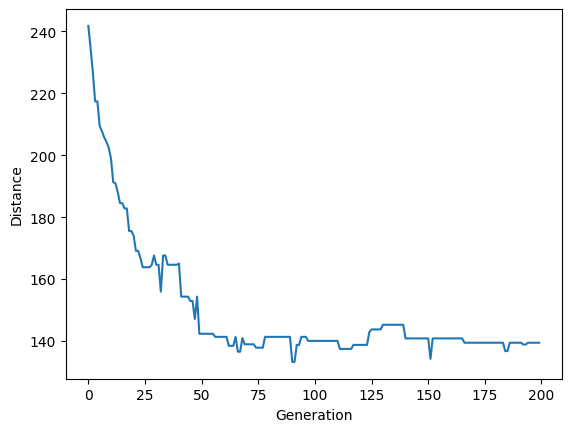

In [52]:
best_route, progress = t_order(distances, pop_size, elite_size, mutation_rate, generations)
print(f"The best calculated route is: \n {1}", best_route)
# Plotting the progress of the algorithm.
plt.plot(progress)
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.show()